In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import geopandas as gpd
from coord_convert.transform import wgs2gcj, wgs2bd, gcj2wgs, gcj2bd, bd2wgs, bd2gcj 
from shapely.geometry import Point,Polygon,shape
import shapely.geometry
import sys
sys.path.append(r'./packages_rely/')
import plot_map
import json
import osmnx as ox
from scipy.spatial.distance import pdist
from scipy import spatial
import math
from math import radians, cos, sin, asin, sqrt
import osmnx as ox
import folium
import os
import copy
from sklearn import preprocessing
plt.rc('font',family='Times New Roman')

# 1.数据读取和特征提取

In [3]:
# 读取拓扑重要性结果
df_top_imp = gpd.read_file('./数据/结点拓扑重要性结果/所有结点拓扑及重要性/所有结点拓扑及重要性.shp')
df_top_imp = df_top_imp[['osmid','impor','geometry']]
df_top_imp.head(2)

,osmid,impor,geometry
0,0,0.000804,POINT (120.23123 30.21360)
1,1,0.001529,POINT (120.23095 30.21403)


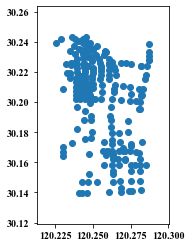

交叉口画像结果：
      impor  nodeid      freq  labels  top_minmax  freq_minmax  \
0  0.074383     514  14097.64       2    0.487439     0.207592   

                     geometry  
0  POINT (120.23909 30.20229)  
临时办事车辆：
   car_num  peak0318  nonpeak0318  peak0319  nonpeak0319  peak0320  \
0  云A00L27       1.0          0.0       0.0          0.0       0.0   

   nonpeak0320  peak0321  nonpeak0321  peak0322  nonpeak0322  \
0          0.0       0.0          0.0       0.0          0.0   

                      feats  fre_peak  fre_nonpeak  traday_peak  \
0  (1.0, nan, 1, 0, 1, 1.0)       1.0          0.0            1   

   traday_nonpeak  traday  fre_avg  
0               0       1      1.0  
频繁过境车辆：
   car_num  peak0318  nonpeak0318  peak0319  nonpeak0319  peak0320  \
0  云A11400       1.0          0.0       0.0          0.0       0.0   

   nonpeak0320  peak0321  nonpeak0321  peak0322  nonpeak0322  \
0          0.0       1.0          0.0       0.0          0.0   

                      feats  

E:\Anaconda\lib\site-packages\pandas\core\frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0, 1, 2, 3, 4}
   car_num  vehlab
0  云A114QQ       1
              camera_idxx   camera_addr          in_time_latest turn_dir  \
0  33010900001320130299xx  风情大道-晨晖路南向北1 2018-11-01 11:28:01.362      南向北   

  camera_type camera_service_ip  channel_id  channel_num        lat  \
0          枪机      33.90.129.76   1000053.0         15.0  30.142625   

          lng  ... citydogcj02lat  citydogcj02lng camera_node node_gcj02lat  \
0  120.251083  ...      30.136641      120.244824    风情大道-晨晖路     30.137144   

   node_gcj02lng                                  lnglat84       lng84  \
0     120.245001  (120.24035064995653, 30.139100201406947)  120.240351   

     lat84  nodeid   dis2node  
0  30.1391     483  51.412587  

[1 rows x 24 columns]


,geometry,nodeid,camera_id
0,POINT (120.23909 30.20229),514,33010900001322920480
1,POINT (120.23909 30.20229),514,33010900001322920479


In [4]:
# 读取交叉口画像结果和车辆画像结果
gdf = gpd.read_file(r'./数据/交叉口画像结果/交叉口画像结果.shp')
gdf.rename(columns={'freq_minma':'freq_minmax'},inplace=True)
gdf.plot()
plt.show()
path = './数据/车辆画像结果/'
df_tem = pd.read_csv(path+"临时办事车辆.csv",encoding='gbk')  # 一周内仅仅出现一天的车辆
df_transit = pd.read_csv(path+'频繁过境车辆.csv',encoding='gbk') # 一周出现大于一天，日均被检测频次小于等于2次的车辆
df_ana = pd.read_csv(path+"聚类画像结果.csv",encoding='gbk') # 聚类画像结果
print("交叉口画像结果：")
print(gdf.head(1))
print("临时办事车辆：")
print(df_tem.head(1))
print("频繁过境车辆：")
print(df_transit.head(1))
print("聚类画像结果：")
print(df_ana.head(1))
df_veh = df_ana[['car_num','labels']]
df_veh.rename(columns={'labels':'vehlab'},inplace=True)
tmp = df_tem[['car_num']]
tmp['vehlab']=3
df_veh = df_veh.append(tmp,ignore_index=False)
tmp = df_transit[['car_num']]
tmp['vehlab']=4
df_veh = df_veh.append(tmp,ignore_index=False)
print(set(df_veh['vehlab']))
print(df_veh.head(1))
# 得到各个交叉口及其映射的电警
# 电警与交叉口映射
# 设备信息表1
dev_df = pd.read_excel("./数据/distinct_camera.xlsx")
dev_df.dropna(how='all',inplace=True,axis=0)
dev_df.dropna(how='all',inplace=True,axis=1)
# 将电警卡口的经纬度转化为84坐标系
def conv284(ser):
    return gcj2wgs(ser[0],ser[1])
    
dev_df['lnglat84'] = dev_df[['citydogcj02lng','citydogcj02lat']].apply(conv284 , axis=1)
dev_df['lng84'] = dev_df[['lnglat84']].applymap(lambda x:x[0])
dev_df['lat84'] = dev_df[['lnglat84']].applymap(lambda x:x[1])
# 读取网络
G = ox.io.load_graphml(filepath='./数据/基于osmnx的路网爬取/graph84坐标系.graphml')
# 将交叉口与电警做映射，算法是利用直线距离最近来匹配
nn, dist = ox.distance.nearest_nodes(G, dev_df['lng84'], dev_df['lat84'], return_dist=True)
dev_df['nodeid'] = nn ; dev_df['dis2node'] = dist
# 将电警与交叉口的映射可视化
dev_df = dev_df[dev_df['dis2node'] < 100]
dev_df.reset_index(drop=True,inplace=True)
print(dev_df.head(1))
#将交叉口画像结果与电警映射
gdf = pd.merge(gdf[['geometry','nodeid']],dev_df[['camera_id','nodeid']],how='inner',on='nodeid')
gdf.head(2)

In [5]:
# 将时间划分成三个时间段：1.00:00-6:30&19:30-24:00; 2.6:30-10:00&17:00-19:30; 3.10:00-17:00,
# 计算各个交叉口各时间段各类型车辆的过车总频次及各类型车辆占比
dict_node_veh = {}
for date in ['0318','0319','0320','0321','0322']:
    df_node_veh = pd.DataFrame([])
    print("{0}日期正在被处理.".format(date))
    # 读取萧山区的电警数据
    path = './数据/萧山市车牌识别数据/'
    df = pd.read_csv(path+date+".csv")
    df.drop(columns=['Unnamed: 0'],inplace=True)
    df.rename(columns={'0':'car_num','1':'cap_date','2':'type','3':'dev_id','4':'dir','5':'road_id','6':'turn_id'},inplace=True)
    # 解决车辆在同一时间同一地点被重复检测问题
    len1 = len(df)
    df = df.drop_duplicates(subset=['car_num' , 'cap_date'])
    print("重复数据占比为{0}".format((len1-len(df)) / len1))
    df = pd.merge(df[['car_num','cap_date','dev_id']],gdf,how = 'inner',left_on='dev_id',right_on='camera_id')
    df.drop(columns=['camera_id'] , inplace=True)
    # 将车辆画像的label也增加进去
    df = pd.merge(df,df_veh,how='inner',on='car_num')
    df['t']=df[['cap_date']].applymap(lambda x:x[11:16])
    # 处理00:00-6:30&21:30-24:00时间段数据
    tmp = df[((df['t']>='00:00')&(df['t']<='06:30'))|((df['t']>='19:30')&(df['t']<='24:00'))]
    tmp = tmp.groupby(['nodeid','vehlab'])[['car_num']].count().reset_index().rename(columns={'car_num':'freq'})
    tmp['time']=0
    df_node_veh = df_node_veh.append(tmp,ignore_index=True)
    # 处理6:30-10:30&15:30-21:30时间段数据
    tmp = df[((df['t']>='06:30')&(df['t']<='10:00'))|((df['t']>='17:00')&(df['t']<='19:30'))]
    tmp = tmp.groupby(['nodeid','vehlab'])[['car_num']].count().reset_index().rename(columns={'car_num':'freq'})
    tmp['time']=1
    df_node_veh = df_node_veh.append(tmp,ignore_index=True)
    # 处理10:30-15:30时间段数据
    tmp = df[((df['t']>='10:00')&(df['t']<='17:00'))]
    tmp = tmp.groupby(['nodeid','vehlab'])[['car_num']].count().reset_index().rename(columns={'car_num':'freq'})
    tmp['time']=2
    df_node_veh = df_node_veh.append(tmp,ignore_index=True)
    df_node_veh.rename(columns={'freq':date},inplace=True)
    df_node_veh = df_node_veh.sort_values(by=['nodeid','vehlab','time'])
    dict_node_veh[date] = df_node_veh
# 将一周的各交叉口各类型车辆占比取均值
for date in ['0319','0320','0321','0322']:
    dict_node_veh['0318']['0318'] = dict_node_veh['0318']['0318'] + dict_node_veh[date][date]
df_avg = dict_node_veh['0318']
df_avg['0318'] = df_avg['0318'] / 5
df_avg.rename(columns={'0318':'freq'},inplace=True)
# 整理格式成透视表,除了nodeid列，其他列第一个字符串是车辆类别（0-4），第二个字符串是时间类别（0-2）
df = df_avg.pivot(index='nodeid',columns=['vehlab','time'],values='freq').reset_index().dropna()
df.columns = list(map(lambda x :str(x[0])+str(x[1]) , df.columns))
df.head(2)

0318日期正在被处理.
重复数据占比为0.09892662759220844
0319日期正在被处理.
重复数据占比为0.10318317668995049
0320日期正在被处理.
重复数据占比为0.1054003294703309
0321日期正在被处理.
重复数据占比为0.09704732091897067
0322日期正在被处理.
重复数据占比为0.1010674548931182


,nodeid,00,01,02,10,11,12,20,21,22,30,31,32,40,41,42
0,21,171.2,2835.0,2554.6,185.6,3304.4,2159.0,160.6,2218.8,2032.2,155.4,1297.4,1267.6,74.2,672.0,2015.6
1,22,184.0,1598.0,3522.4,210.4,1541.8,2838.6,169.2,1061.4,2915.8,136.0,682.2,1811.4,47.8,610.2,1043.6


In [12]:
# 将拓扑重要性结果和各时段被检测频次合并在一起
df=pd.merge(df,df_top_imp,how='inner',left_on='nodeid',right_on='osmid')
df.head(2)

,nodeid,00,01,02,10,11,12,20,21,22,30,31,32,40,41,42,osmid,impor,geometry
0,21,171.2,2835.0,2554.6,185.6,3304.4,2159.0,160.6,2218.8,2032.2,155.4,1297.4,1267.6,74.2,672.0,2015.6,21,0.014461,POINT (120.26848 30.22620)
1,22,184.0,1598.0,3522.4,210.4,1541.8,2838.6,169.2,1061.4,2915.8,136.0,682.2,1811.4,47.8,610.2,1043.6,22,0.014462,POINT (120.28227 30.22416)


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_dis

2 clustering method has been successfully run
3 clustering method has been successfully run
4 clustering method has been successfully run
5 clustering method has been successfully run
6 clustering method has been successfully run
7 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_dis

8 clustering method has been successfully run
9 clustering method has been successfully run
10 clustering method has been successfully run
11 clustering method has been successfully run


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


12 clustering method has been successfully run


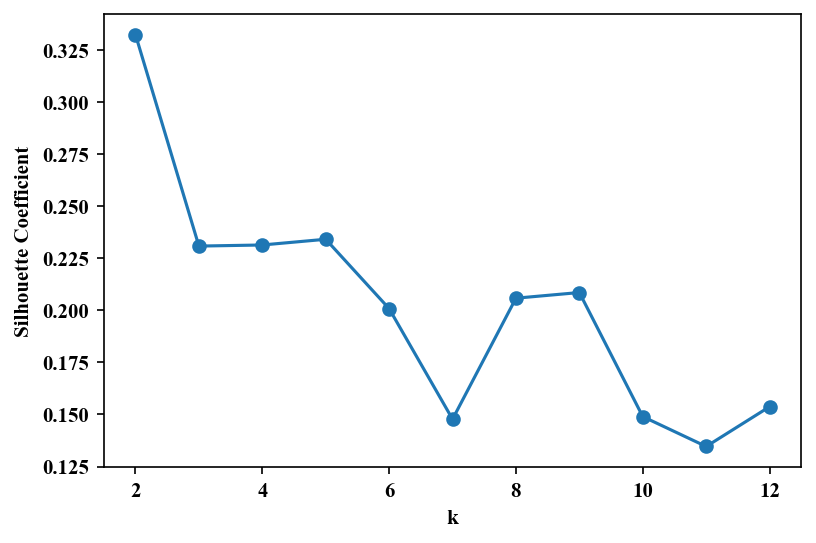

In [26]:
# 将交叉口进行聚类分析
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
plt.rcParams['figure.dpi'] = 150 #分辨率
Scores = [] # 存储不同初始聚类数目的轮廓系数值
data = df[['00','01','02','10','11','12','20','21','22','30','31','32','40','41','42','impor']].values
min_max_scaler = preprocessing.MinMaxScaler()
data_minmax = min_max_scaler.fit_transform(data)
for k in range(2,13):  
    estimator = KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器  
    labels = estimator.fit_predict(data_minmax)  
    Scores.append(silhouette_score(data_minmax , labels , random_state=0))  
    print("{0} clustering method has been successfully run".format(k))
X = range(2,13)  
plt.xlabel('k')  
plt.ylabel('Silhouette Coefficient')  
plt.plot(X,Scores,'o-')  
plt.show()

In [27]:
# 聚类成2个簇看一下结果
estimator = KMeans(n_clusters=2,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器
labels = estimator.fit_predict(data_minmax)
print(silhouette_score(data_minmax , labels , random_state=0))
df['labels'] = labels
df.head(2)

0.3322589314171372


E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


,nodeid,00,01,02,10,11,12,20,21,22,30,31,32,40,41,42,osmid,impor,geometry,labels
0,21,171.2,2835.0,2554.6,185.6,3304.4,2159.0,160.6,2218.8,2032.2,155.4,1297.4,1267.6,74.2,672.0,2015.6,21,0.014461,POINT (120.26848 30.22620),0
1,22,184.0,1598.0,3522.4,210.4,1541.8,2838.6,169.2,1061.4,2915.8,136.0,682.2,1811.4,47.8,610.2,1043.6,22,0.014462,POINT (120.28227 30.22416),0


In [28]:
for i in range(2):
    print("第%s个簇的描述性统计："%i)
    print(df[df['labels'] == i].describe())

第0个簇的描述性统计：
           nodeid          00           01           02           10  \
count  141.000000  141.000000   141.000000   141.000000   141.000000   
mean   549.212766  324.229787  2600.609929  1285.126241   504.892199   
std    254.081646  183.195429  1282.868386   669.265806   291.294668   
min     21.000000   15.000000   584.800000   145.200000    32.600000   
25%    354.000000  179.000000  1620.000000   790.800000   269.800000   
50%    539.000000  284.200000  2348.800000  1231.400000   470.000000   
75%    796.000000  453.400000  3270.800000  1689.600000   673.400000   
max    893.000000  933.200000  7788.600000  3522.400000  1350.400000   

                11           12           20           21           22  \
count   141.000000   141.000000   141.000000   141.000000   141.000000   
mean   3058.995745  1049.195745   408.506383  2516.340426  1076.567376   
std    1504.985852   569.121822   271.526032  1220.839605   548.404817   
min     636.800000   152.600000    27.40000